# Лабораторная работа №1. Генетические алгоритмы

## Общее задание
1. Необходимо разработать программу на языке python, реализующую генетический алгоритм по предложенному вариантом заданию.
2. Провести эксперименты по разным способам скрещивания (не менее 3-х), разным способам мутирования (не менее трех). Результат отобразить в виде графиков
3. Моделирование данных производить на основе максимально правдоподобных данных. Т.е. если рассматривается задача, в которой есть калорийность продуктов, то должны использоваться данные о реальных продуктах с реальной калорийностью.
4. Предоставить отчет о проделанной работе. 

## Вариант
16.	На языке Python разработайте скрипт, который с помощью генетического алгоритма и полного перебора решает следующую задачу. Дано N наименований продуктов, для каждого из которых известно m характеристик. Необходимо получить самый дешевый рацион из k наименований, удовлетворяющий заданным медицинским нормам для каждой из m характеристик.

## Контрольные вопросы по лабораторной работе:

1.	Какова структура хромосомы для вашей задачи?
2.	Какую функцию приспособленности вы выбрали и почему?
3.	Что такое кроссовер и мутация?


## Ссылки
1. https://proproprogs.ru/ga/ga-osnovnye-etapy-raboty-geneticheskogo-algoritma
2. В.В.Воронина. Методы искусственного интеллекта и машинное обучение. Методические указания. 

--- Запуск Генетического Алгоритма ---

--- Сводка результатов ГА ---
   crossover      mutation  price  fitness
0  one_point       bitflip  155.0    155.0
1  one_point  random_reset  155.0    155.0
2  one_point          swap  155.0    155.0
3  two_point       bitflip  174.0    174.0
4  two_point  random_reset  155.0    155.0
5  two_point          swap  155.0    155.0
6    uniform       bitflip  155.0    155.0
7    uniform  random_reset  155.0    155.0
8    uniform          swap  155.0    155.0

--- Лучший рацион, найденный ГА ---
Комбинация: one_point + bitflip
Рацион: Макароны из муки высшего сорта, Грибы шампиньоны (свежие), Колбаса докторская, Картофель (вареный), Яблоко (свежее), Груша (свежее)
Ккал=686.7, Белки=23.6, Жиры=27.2, Углеводы=106.1
Цена=155.00, Fitness (целевая функция)=155.00

--- Решение полным перебором ---
Рацион: Макароны из муки высшего сорта, Грибы шампиньоны (свежие), Колбаса докторская, Картофель (вареный), Яблоко (свежее), Груша (свежее)
Ккал=686.7, Белки=23.

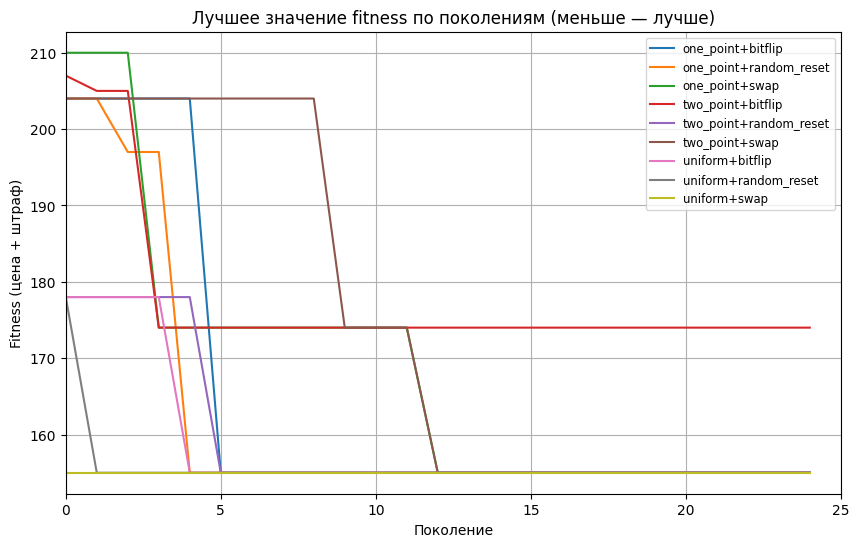

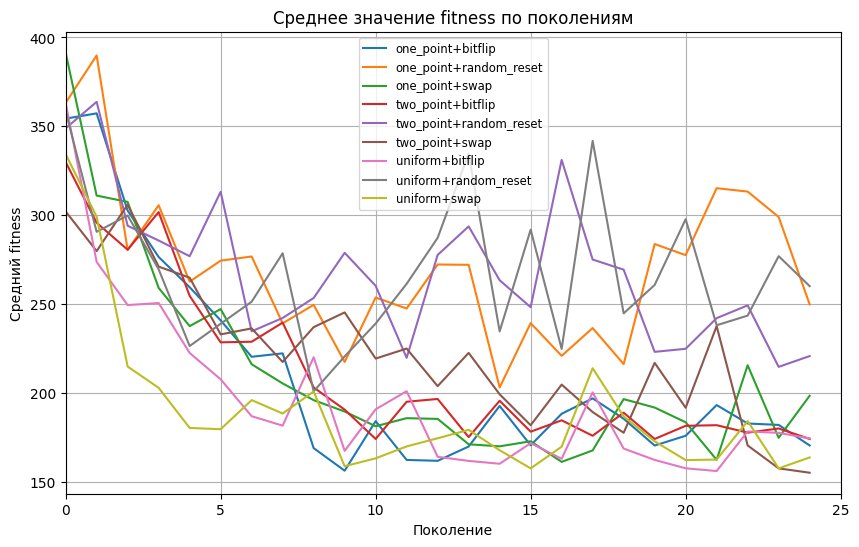

In [10]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

products = [
# Структура: (Название, Ккал, Белки (г), Жиры (г), Углеводы (г), Цена (руб))
    ("Макароны из муки высшего сорта", 338, 11.0, 1.3, 70.5, 19),
    ("Грибы лисички (свежие)", 19, 1.5, 1, 1, 40),
    ("Грибы шампиньоны (свежие)", 22, 2.5, 0.1, 3.7, 17),
    ("Стейк говяжий (жареный)", 123, 19.0, 5.0, 0.0, 150.0),
    ("Колбаса докторская", 200, 9.0, 25.0, 0.0, 101.0),
    ("Сыр с Белыми Грибами [Ларец].", 377, 23.7, 30.5, 0, 120.0),
    ("Картофель (вареный)", 17.7, 0.4, 0.5, 2.9, 5.0),
    ("Яблоко (свежее)", 52, 0.3, 0.2, 14.0, 6.0),
    ("Груша (свежее)", 57, 0.4, 0.1, 15.0, 7.0),
    ("Голубика (свежая)", 39, 1, 0.5, 6.6, 55.0),
]

N = len(products)
K = 6  # выбрать ровно K продуктов

# Нормы
norms = {
    "kcal_min": 500,
    "kcal_max": 2000,
    "protein_min": 20,
    "fat_max": 60,
    "carbs_max": 300,
}

# Параметры GA
POP = 20 # Размер популяции.
GEN = 25 # Количество поколений
ELITISM = 2 # Количество элитных(лучших) особей, хр-ки которых переходят без изменений
TOURNAMENT_SIZE = 2 # Количество особей в одной группе отбора

P_MUT = 0.15 # Вероятность мутации
P_CROSS = 0.8 # Вероятность скрещивания
PENALTY_WEIGHT = 1000  # штраф

random.seed(1)  # для воспроизводимости

def get_selected_indexes(chrom):
    """Возвращает список индексов выбранных продуктов из битовой маски."""
    return [i for i in range(N) if chrom & (1 << i)]

def generate_random_chrom():
    """Генерирует случайную хромосому, выбирая ровно K продуктов."""
    bits = random.sample(range(N), K)
    x = 0
    for b in bits:
        x |= (1 << b)
    return x

def totals_for_inds(inds):
    """Суммирует Ккал, Б, Ж, У и Цену для выбранных индексов."""
    kcal = 0; protein = 0; fat = 0; carbs = 0; price = 0
    for i in inds:
        kcal += products[i][1]
        protein += products[i][2]
        fat += products[i][3]
        carbs += products[i][4]
        price += products[i][5]
    return kcal, protein, fat, carbs, price

def fitness(chrom, penalty_weight=PENALTY_WEIGHT):
    """Относительная функция приспособленности."""
    inds = get_selected_indexes(chrom)
    kcal, protein, fat, carbs, price = totals_for_inds(inds)

    penalty = 0

    # Ккал: недобор и перебор относительно диапазона
    if kcal < norms["kcal_min"]:
        penalty += (norms["kcal_min"] - kcal) / norms["kcal_min"]
    elif kcal > norms["kcal_max"]:
        penalty += (kcal - norms["kcal_max"]) / norms["kcal_max"]

    # Белок: только недобор
    if protein < norms["protein_min"]:
        penalty += (norms["protein_min"] - protein) / norms["protein_min"]

    # Жир: только перебор
    if fat > norms["fat_max"]:
        penalty += (fat - norms["fat_max"]) / norms["fat_max"]

    # Углеводы: только перебор
    if carbs > norms["carbs_max"]:
        penalty += (carbs - norms["carbs_max"]) / norms["carbs_max"]

    return price + penalty_weight * penalty

def repair(chrom):
    """
    Восстановление: гарантирует, что выбрано ровно K продуктов.
    Если > K — удаляет случайные; если < K — добавляет случайные.
    """
    bits = get_selected_indexes(chrom)
    bits = list(bits)
    # если битов больше K — удаляем случайно
    while len(bits) > K:
        bits.pop(random.randrange(len(bits)))
    # если меньше — добавляем случайные, которых нет
    while len(bits) < K:
        j = random.randrange(N)
        if j not in bits:
            bits.append(j)
    x = 0
    for b in bits:
        x |= (1 << b)
    return x

# Скрещивания
def one_point_crossover(a, b):
    point = random.randint(1, N - 1)   # выбираем случайную точку разреза
    mask = (1 << point) - 1          # создаём маску для "левой части"
    c1 = (a & mask) | (b & ~mask)    # хромосома 1: левая часть от a, правая от b
    c2 = (b & mask) | (a & ~mask)    # хромосома 2: левая часть от b, правая от a
    return repair(c1), repair(c2)

def two_point_crossover(a, b):
    p1 = random.randint(1, N-2)      # первая точка
    p2 = random.randint(p1+1, N-1)   # вторая точка
    mask = ((1 << (p2 - p1)) - 1) << p1  # маска для промежутка между p1 и p2
    c1 = (a & ~mask) | (b & mask)    # хромосома 1: средний кусок от b
    c2 = (b & ~mask) | (a & mask)    # хромосома 2: средний кусок от a
    return repair(c1), repair(c2)

def uniform_crossover(a, b):
    c1 = 0
    c2 = 0
    for i in range(N):
        if random.random() < 0.5: # 50% шанс
            # c1 берет от a, c2 от b
            if a & (1 << i): c1 |= (1 << i)
            if b & (1 << i): c2 |= (1 << i)
        else:
            # c1 берет от b, c2 от a
            if b & (1 << i): c1 |= (1 << i)
            if a & (1 << i): c2 |= (1 << i)
    return repair(c1), repair(c2)

# Мутации
def mutate_bitflip(chrom, prob=P_MUT):
    """Случайным образом меняет состояние (0->1 или 1->0) одного бита."""
    if random.random() < prob:
        i = random.randrange(N)
        chrom ^= (1 << i)
    return repair(chrom)

def mutate_random_reset(chrom, prob=P_MUT) -> int:
    """Случайным образом сбрасывает (делает 0) один или несколько битов."""
    for pos in range(N):
        if random.random() < prob:
            chrom &= ~(1 << pos)  # сбросить бит
    return repair(chrom)

def mutate_swap(chrom, prob=P_MUT):
    """Меняет местами один выбранный продукт (1) и один невыбранный (0)."""
    if random.random() < prob:
        bits = get_selected_indexes(chrom)
        zeros = [i for i in range(N) if i not in bits]
        if bits and zeros:
            sel = random.choice(bits)
            new = random.choice(zeros)
            # Убираем старый бит (sel) и добавляем новый (new)
            chrom &= ~(1 << sel) # сбросить
            chrom |= (1 << new)  # установить
            return chrom
    return chrom # Возвращаем исходную хромосому, если мутация не произошла

# Селекция
def tournament_select(pop, k=TOURNAMENT_SIZE):
    """Турнирная селекция: выбираем лучшую особь из k случайных."""
    a = random.sample(pop, k)
    return min(a, key=fitness)

def run_ga(crossover_f, mutate_f, pop_size=POP, gens=GEN):
    """Основной цикл генетического алгоритма."""
    pop = [generate_random_chrom() for _ in range(pop_size)]
    history_best = []
    history_mean = []

    for g in range(gens):
        pop.sort(key=fitness)
        fitnesses = [fitness(x) for x in pop]
        history_best.append(min(fitnesses))
        history_mean.append(sum(fitnesses)/len(fitnesses))

        new_pop = pop[:ELITISM]  # Элитизм

        while len(new_pop) < pop_size:
            parent1 = tournament_select(pop)
            parent2 = tournament_select(pop)
            
            # Скрещивание или копирование
            if random.random() < P_CROSS:
                c1, c2 = crossover_f(parent1, parent2)
            else:
                c1 = parent1
                c2 = parent2

            # Мутация
            c1 = mutate_f(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c1)
            if len(new_pop) < pop_size:
                c2 = mutate_f(c2)
                new_pop.append(c2)

        pop = new_pop

    # Финальный лучший
    best = min(pop, key=fitness)

    return best, history_best, history_mean

def pretty_print_solution(chrom):
    """Форматирует решение для вывода."""
    inds = get_selected_indexes(chrom)
    names = [products[i][0] for i in inds]
    kcal, protein, fat, carbs, price = totals_for_inds(inds)
    s = {}
    s["names"] = ", ".join(names)
    s["inds"] = inds
    s["kcal"] = kcal
    s["protein"] = protein
    s["fat"] = fat
    s["carbs"] = carbs
    s["price"] = price
    s["fitness"] = fitness(chrom)
    return s

# Комбинации функций
crossovers = {
    "one_point": one_point_crossover,
    "two_point": two_point_crossover,
    "uniform": uniform_crossover
}

mutations = {
    "bitflip": mutate_bitflip,
    "random_reset": mutate_random_reset,
    "swap": mutate_swap,
}

# Собираем истории для всех комбинаций
histories_mean = []
histories_best = []
results = []

def main():
    print("--- Запуск Генетического Алгоритма ---")
    for cross_name, cross_f in crossovers.items():
        for mut_name, mut_f in mutations.items():
            best, history_best, history_mean = run_ga(cross_f, mut_f)
            sol = pretty_print_solution(best)
            sol["crossover"] = cross_name
            sol["mutation"] = mut_name
            results.append(sol)

            histories_mean.append((cross_name, mut_name, history_mean))
            histories_best.append((cross_name, mut_name, history_best))

    # Лучший результат ГА
    df = pd.DataFrame(results)
    best_ga_row = df.loc[df["fitness"].idxmin()]

    print("\n--- Сводка результатов ГА ---")
    print(df[["crossover", "mutation", "price", "fitness"]])
    print("\n--- Лучший рацион, найденный ГА ---")
    print(f"Комбинация: {best_ga_row['crossover']} + {best_ga_row['mutation']}")
    print(f"Рацион: {best_ga_row['names']}")
    print(f"Ккал={best_ga_row['kcal']:.1f}, Белки={best_ga_row['protein']:.1f}, Жиры={best_ga_row['fat']:.1f}, Углеводы={best_ga_row['carbs']:.1f}")
    print(f"Цена={best_ga_row['price']:.2f}, Fitness (целевая функция)={best_ga_row['fitness']:.2f}")

    # Полный перебор
    def brute_force_solve(products, K, norms):
        """Решает задачу полным перебором всех комбинаций."""
        N = len(products)
        best_chrom = None
        min_fitness = float('inf')
        
        # Итерация по всем комбинациям K индексов из N
        for selected_indices in combinations(range(N), K):
            
            # Создаем битовую маску
            chrom = 0
            for i in selected_indices:
                chrom |= (1 << i)

            current_fitness = fitness(chrom)

            if current_fitness < min_fitness:
                min_fitness = current_fitness
                best_chrom = chrom
                
        return best_chrom, min_fitness

    best_brute_force_chrom, min_brute_force_fitness = brute_force_solve(products, K, norms)
    brute_force_sol = pretty_print_solution(best_brute_force_chrom)

    print("\n--- Решение полным перебором ---")
    print(f"Рацион: {brute_force_sol['names']}")
    print(f"Ккал={brute_force_sol['kcal']:.1f}, Белки={brute_force_sol['protein']:.1f}, Жиры={brute_force_sol['fat']:.1f}, Углеводы={brute_force_sol['carbs']:.1f}")
    print(f"Цена={brute_force_sol['price']:.2f}, Fitness (целевая функция)={brute_force_sol['fitness']:.2f}")

    if abs(best_ga_row['fitness'] - brute_force_sol['fitness']) < 0.001:
        print("\nГенетический алгоритм нашел оптимальное решение, соответствующее полному перебору.")
    else:
        print("\nГенетический алгоритм не нашел оптимальное решение, найденное полным перебором.")

    plt.figure(figsize=(10,6))
    for (cross_name, mut_name, history) in histories_best:
        label = f"{cross_name}+{mut_name}"
        plt.plot(history, label=label)
    plt.title("Лучшее значение fitness по поколениям (меньше — лучше)")
    plt.xlabel("Поколение")
    plt.xlim(0, GEN)
    plt.ylabel("Fitness (цена + штраф)")
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,6))
    for (cross_name, mut_name, history) in histories_mean:
        label = f"{cross_name}+{mut_name}"
        plt.plot(history, label=label)
    plt.title("Среднее значение fitness по поколениям")
    plt.xlabel("Поколение")
    plt.xlim(0, GEN)
    plt.ylabel("Средний fitness")
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.show()
main()